In [1]:
import keras
from keras.models import model_from_json
import bars
from matplotlib import pyplot as plt
import numpy as np
import os.path

/Users/mitsuiyasuyuki/.pyenv/versions/machineLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from enum import Enum
class BuySellType(Enum):
    BUY = 1
    SELL = 2

In [3]:
class Trade:
    def __init__(self, id, time, symbolCode, buySellType, volume, price, isClose, closePositionId, pl):
        # ID
        self.id = id;
        # 取引時刻
        self.time = time;
        # 取引銘柄コード
        self.symbolCode = symbolCode;
        # 売買区分
        self.buySellType = buySellType;
        # 取引数量
        self.volume = volume;
        # 取引価格
        self.price = price;
        # 決済取引Frag
        self.isClose = isClose;
        # 決済対象建玉
        self.closePositionId = closePositionId;
        # 決済損益
        self.pl = pl;

In [4]:
class Position:
    def __init__(self, trade):
        # ID
        self.id = trade.id;
        # 取引時刻
        self.time = trade.time;
        # 取引銘柄コード
        self.symbolCode = trade.symbolCode;
        # 売買区分
        self.buySellType = trade.buySellType;
        # 取引数量
        self.volume = trade.volume;
        # 取引価格
        self.price = trade.price;
        

In [5]:
spreads = 0.005
class TradeSimulation:
    def __init__(self):
        self.trades = []
        self.positions = []
        self.asset = 0
        self.asset_hist = [0]
        
    def new_trade(self, buySellType, volume, price):
        trade = Trade(None, None, None, buySellType, volume, price, False, None, None)
        position = Position(trade)
        self.trades.append(trade)
        self.positions.append(position)
        
    def close_trade(self, buySellType, volume, price):
        target_type = BuySellType.SELL
        if buySellType == BuySellType.SELL:
            target_type = BuySellType.BUY
        
        close_pl = 0
        while volume > 0 :
            close_position = [position for position in self.positions if position.buySellType == target_type][0]
            self.positions.remove(close_position)
            close_volume = min(volume, close_position.volume)
            if buySellType == BuySellType.SELL:
                close_pl += (price - close_position.price - spreads) * close_volume
            else :
                close_pl += (close_position.price - price - spreads) * close_volume
            
            volume -= close_volume
        
        trade = Trade(None, None, None, buySellType, volume, price, True, None, close_pl)
        self.trades.append(trade)
        
        self.asset_hist.append(self.asset + close_pl)
        self.asset += close_pl
    
    def close_all(self, buySellType, price):
        target_type = BuySellType.SELL
        if buySellType == BuySellType.SELL:
            target_type = BuySellType.BUY
            
        volume = 0
        for close_position in [position for position in self.positions if position.buySellType == target_type]:
            volume += close_position.volume
            
        self.close_trade(buySellType, volume, price)

In [10]:
class TradeRule:
    def __init__(self):
        f_model = './model'
        model_name = 'ma_30m_cnn_model_1.json'
        weight_name = 'ma_30m_cnn_weight_1.hdf5'
        
        json_string = open(os.path.join(f_model, model_name)).read()
        self.model = model_from_json(json_string)
        self.model.load_weights(os.path.join(f_model,weight_name))
        
    def predict(self, test):
        self.pred_data = self.model.predict(test)
        
    def new_buy_trade(self, positions):
        if self.pred_data[0][0] < 0.45 or self.pred_data[0][0] < self.pred_data[0][1]:
            return False
        
        if self.pred_data[0][0] < 0.50:
            return len([p for p in positions if p.buySellType == BuySellType.BUY]) < 1 
        
        if self.pred_data[0][0] < 0.55:
            return len([p for p in positions if p.buySellType == BuySellType.BUY]) < 2 
        
        if self.pred_data[0][0] < 0.60:
            return len([p for p in positions if p.buySellType == BuySellType.BUY]) < 3 
        
        return len([p for p in positions if p.buySellType == BuySellType.BUY]) < 10
    
    def new_sell_trade(self, positions):
        if self.pred_data[0][1] < 0.45 or self.pred_data[0][0] > self.pred_data[0][1]:
            return False
        
        if self.pred_data[0][1] < 0.50:
            return len([p for p in positions if p.buySellType == BuySellType.SELL]) < 1 
        
        if self.pred_data[0][1] < 0.55:
            return len([p for p in positions if p.buySellType == BuySellType.SELL]) < 2 
        
        if self.pred_data[0][1] < 0.60:
            return len([p for p in positions if p.buySellType == BuySellType.SELL]) < 3 
        
        return len([p for p in positions if p.buySellType == BuySellType.SELL]) < 10
    
    def close_buy_trade(self, positions):
        if len([p for p in positions if p.buySellType == BuySellType.SELL]) == 0 :
            return False
        
        return self.pred_data[0][0] > self.pred_data[0][1] 
    
    def close_sell_trade(self, positions):
        if len([p for p in positions if p.buySellType == BuySellType.BUY]) == 0 :
            return False
        
        return self.pred_data[0][0] < self.pred_data[0][1] 

In [11]:
rows = 10
cols = 14

(x_base, y_base),(x_test, y_test)= bars.load_bars(rows, normalize=False)
x_test = x_base.reshape(x_base.shape[0], rows, cols, 1)
#x_test = x_base[train_size:]
#x_test = x_base


In [14]:
simulator = TradeSimulation()
rule = TradeRule()

for i in range(len(x_test)):
    if i == 0:
        continue
        
    test = x_test[i-1]
    price = x_test[i][-1][3]
    test = test - np.amin(test)
    test = test / np.amax(test)
    rule.predict(test.reshape(1, rows, cols, 1))
    
    if rule.close_buy_trade(simulator.positions):
        simulator.close_all(BuySellType.BUY, price)
        
    if rule.close_sell_trade(simulator.positions):
        simulator.close_all(BuySellType.SELL, price)
        
    if rule.new_buy_trade(simulator.positions):
        simulator.new_trade(BuySellType.BUY, 1, price)
        
    if rule.new_sell_trade(simulator.positions):
        simulator.new_trade(BuySellType.SELL, 1, price)
        
    
    
print(len(simulator.trades))

18465


In [13]:
pl = 0
for t in [t for t in simulator.trades if t.isClose]:
    pl += t.pl
print(pl)

[4707.67]


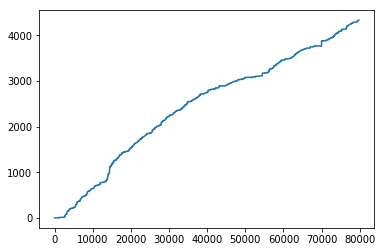

In [30]:
plt.plot(simulator.asset_hist,label="asset history")
plt.show()